# Working with GeoPandas and PySAL

We've worked -- and will continue to work -- a lot with pandas, but by default pandas doesn't help us much when want to start working with explicitly geographical data. Ways of working _computationally_ with things like distance and location are increasingly important not only to geographers, but also to data scientists, and this is where we start to move away from purely aspatial statistical analysis into the foundations of a more _geographic_ data science.

There are a huge number of modules in Python designed to help you work with geodata, but we are going to focus on the two most important higher-level libraries (since they also provide 'wrappers' around some of the lower-level libraries):

1. [GeoPandas](http://geopandas.org/) -- which offers a pandas-like interface to working with geodata. Think of this as your tool for basic data manipulation and transformation, much like pandas. You will almost certainly want to [bookmark the documentation](http://geopandas.org/user.html#geodataframe).
2. [PySAL](http://pysal.readthedocs.io/en/latest/) -- the Python Spatial Analysis Library  provides the spatial analytic functions that we'll need for everything from classification, clustering and point-pattern analysis to autocorrelation-based tools.
3. There is some overlap between the two libraries: both can do plotting but, for reasons we'll see later, we'll normally do this in PySAL and both can do classification (remember, we did _quantiles_ with pandas!) but (again), for reasons we'll see later, we'll often do this in PySAL from here on out.

PySAL is complicated enough that the best way to understand how it fits together is to use an image:

![PySAL Logo](http://darribas.org/gds_scipy16/content/figs/pysal.png)

We're going to concentrate primarily on the ESDA (Exploratory _Spatial_ Data Analysis) and Weights components of PySAL in this module, but you should know about the other bits!

## Required Preamble

It makes life a lot easier if you make all of the library import commands and configuration information (here having to do with `matplotlib`) the first exectuable code in a notebook or script. That way it's easy to see what you need to have installed before you get started!

You'll notice that I've broken my own 'rule' a little later when we get to PySAL but that's because I didn't want you to have no idea where some of the commands are coming from!

In [1]:
import matplotlib as mpl
mpl.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import pysal as ps
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.cm as cm
import urllib
import zipfile
import re
import os

In [4]:
# Make numeric display a bit easier
pd.set_option('display.float_format', lambda x: '{:,.0f}'.format(x))

def download_gsa_data(src='https://github.com/kingsgeocomp/geocomputation/blob/master/data/LSOA%20Data.csv.gz?raw=true', dst='lsoa.csv.gz', srczip='gzip'):
    """
    A simple function to help simplify the process of downloading
    and saving data to use in a practical. To save on bandwidth, 
    the function will first check whether a local copy of the file
    exists (as specified by the dst parameter) before attempting to
    read it from the remote source (as specified by the src parameter).
    
    
    Keyword arguments:
    src -- a remote URL to use as a source (default http://bit.ly/2g4Iz3v)
    dst -- a local path to use as a destination (default lsoa.csv.gz)
    """
    dst_compression='gzip'
    
    # Check if local copy exists...
    if os.path.exists(dst):
        # Yes, then just read and return the data frame
        print("File already downloaded.")
        # The 'low memory' option means pandas doesn't guess data types
        df = pd.read_csv(dst, compression=dst_compression, low_memory=False)
        
    else:
        # No, then download and save a local copy
        print("Downloading remote data...")
        
        # It is possible to have a remote file with no
        # compression so this is just a piece of forward
        # looking code....
        if srczip is not None:
            # The 'low memory' option means pandas doesn't guess data types
            df = pd.read_csv(src, compression=srczip, low_memory=False)
        else:
            df = pd.read_csv(src, low_memory=False)
        
        # And save it
        print("Writing to local file...")
        df.to_csv(dst, compression=dst_compression, index=False)
    print("Done.")
    return df

## Getting the Data

We're going to work with three data sets this week:

1. The LSOA CSV data we've been using already.

2. A zipfile containing LSOA _geometries_.

3. A gzip file containing data [scraped from Airbnb](http://insideairbnb.com/get-the-data.html).

In [5]:
df = download_gsa_data()
df.set_index(['LSOA11CD'], drop=True, inplace=True)

Writing to local file...
Done.


In [5]:
df.head(2)

,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,...,SumPrice,MeanPrice,MedianPrice,EntireHome,PrivateRoom,SharedRoom,SmallHost,MultiHost,PropertyCount,Area
LSOA11CD,,,,,,,,,,,,,,,,,,,,,
E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,E12000007,London,1465,1465,0,...,"2,589",152,146,14,1,2,11,6,17,"133,321"
E01000002,City of London 001B,E02000001,City of London 001,E09000001,City of London,E12000007,London,1436,1436,0,...,"2,697",150,118,12,5,1,13,5,18,"226,191"


In [3]:
def download_gsa_geodata(src_dir, dst_dir, ddir):

    if not os.path.exists(dst_dir):
        if not os.path.exists(os.path.dirname(dst_dir)):
            os.makedirs(os.path.dirname(dst_dir))
        urllib.urlretrieve(src_dir, dst_dir)

    if not os.path.exists(ddir):
        os.makedirs(os.path.dirname(ddir))
    
    zp = zipfile.ZipFile(dst_dir, 'r')
    zp.extractall(ddir)
    zp.close()    

    print("Done.")

# See how this function allows us to download data to a particular directory
src = 'https://github.com/kingsgeocomp/geocomputation/blob/master/data/LSOAs.zip?raw=true'
dst = 'shapes/LSOAs.zip'
zpd = 'shapes/'
download_gsa_geodata(src, dst, zpd)

# And now we just do the same on the next file
src = 'https://github.com/kingsgeocomp/geocomputation/blob/master/data/Greenspace.zip?raw=true'
dst = 'shapes/Greenspace.zip'
download_gsa_geodata(src, dst, zpd)

# And again
src = 'https://github.com/kingsgeocomp/geocomputation/blob/master/data/Roads.zip?raw=true'
dst = 'shapes/Roads.zip'
download_gsa_geodata(src, dst, zpd)

# And again
src = 'https://github.com/kingsgeocomp/geocomputation/blob/master/data/Boroughs.zip?raw=true'
dst = 'shapes/Boroughs.zip'
download_gsa_geodata(src, dst, zpd)

print("All done...")

Done.
Done.
Done.
Done.
All done...


## Reading a Shapefile with GeoPandas

Let's set up some simple variables to store references to the shape file (where the geometry is stored) and the DBF file (where the data is stored).

In [7]:
shp_path = os.path.join('shapes','lsoas','Lower_Layer_Super_Output_Areas_December_2011_Generalised_Clipped__Boundaries_in_England_and_Wales.shp')
print("Loading data from: " + shp_path)

Loading data from: shapes\lsoas\Lower_Layer_Super_Output_Areas_December_2011_Generalised_Clipped__Boundaries_in_England_and_Wales.shp


In other words, depending on your setup you might need to tweak the path in the code below to get your own code working...

In [8]:
gdf = gpd.read_file(shp_path)
gdf.set_index('lsoa11cd', drop=True, inplace=True)
gdf.head(3)

,objectid,lsoa11nm,lsoa11nmw,st_areasha,st_lengths,geometry
lsoa11cd,,,,,,
E01000001,1,City of London 001A,City of London 001A,"133,321","2,292","POLYGON ((532106.8939689073 182011.4758723566,..."
E01000002,2,City of London 001B,City of London 001B,"226,191","2,434","POLYGON ((532748.6236845022 181787.1247154782,..."
E01000003,3,City of London 001C,City of London 001C,"57,303","1,142","POLYGON ((532136.9496997485 182198.3681596624,..."


So far so good! Notice that even the output of the `head` function is the same as from pandas. The only obvious difference so far is that `geometry` column on the right-hand side which doesn't contain numbers or strings, but `POLYGON`s. In a nutshell, aside from the ability to read geodata directly (we just loaded a shapefile using only code!) this geometry column is the other marker of a big step from pandas to geopandas.

But let's dig a little deeper:

In [9]:
print("Let's look at inheritance: ")

if isinstance(gdf, gpd.GeoDataFrame): # Is gdf a GeoDataFrame object?
    print("\tI'm a geopandas data frame!")

if isinstance(gdf, pd.DataFrame): # Is gdf *also* a DataFrame object?
    print("\tI'm also a pandas data frame!")

print("-" * 50)

print("Let's look at some pandas methods we know: ") # See inheritance in action

print("Using the 'sample()' method: ")
print(gdf.sample(3))
print("-" * 50)

print("What is the lsoa11nm column type: ")
print('\tNAME type: ' + str(type(gdf.lsoa11nm)))
print("-" * 50)

print("Describe the column: ")
print(gdf.lsoa11nm.describe())
print("-" * 50)

print("Let's look at some new methods from geopandas: ") # Here's stuff pandas can't do

print("What's the geometry column type: ")
print('\tGeometry type: ' + str(type(gdf.geometry)))
print("-" * 50)

# The next line is very slow, don't run it:
# print(gdf.geometry.describe())
# print("-" * 50)

print("Is there projection information: ")
print('\tCRS: ' + str(gdf.crs))
print("-" * 50)

Let's look at inheritance: 
	I'm a geopandas data frame!
	I'm also a pandas data frame!
--------------------------------------------------
Let's look at some pandas methods we know: 
Using the 'sample()' method: 
           objectid       lsoa11nm      lsoa11nmw  st_areasha  st_lengths  \
lsoa11cd                                                                    
E01003408      3335    Merton 012D    Merton 012D     161,638       1,870   
E01002617      2560  Hounslow 028D  Hounslow 028D     454,820       2,974   
E01001275      1256    Ealing 020H    Ealing 020H     345,800       3,807   

                                                    geometry  
lsoa11cd                                                      
E01003408  POLYGON ((526770.6888349364 169744.4153100731,...  
E01002617  POLYGON ((510930.8856810229 172207.3573899338,...  
E01001275  (POLYGON ((518322.4057272299 181864.608075981,...  
--------------------------------------------------
What is the lsoa11nm column type: 


This next command may take a while to complete -- the geopandas developers know that their mapping code is sloooooooooow, and that's one of the reasons we're going to use PySAL for most of our work. But 'watch this space' since they are working on it and there may even be an update this year that addresses the single biggest complaint that people have about geopandas.

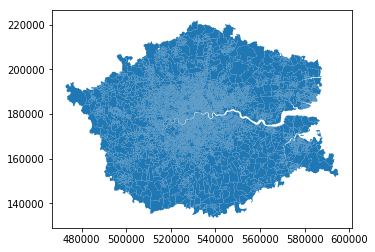

In [10]:
gdf.plot()

**Some questions for you:**

1. What type of data structure is the CRS attribute of the geopandas data frame?
2. How would you confirm this?
3. Can you figure out how to reproject the data using the geopandas documentation?
4. What is the data structure of the geometry column (broadly)?
5. Are there any differences between what a similar pandas data frame would give you if you ran any of the non-geographic commands?

## Joining Geo- and Non-Geo-Data

If you look at the data above, you'll see that we have none of the LSOA data that we want to work with available to us. That's obviously because that data is in `df`, while the geo-data is in `gdf`. So how to join them?

Easy! Since Geopandas inherits from Pandas, it recognises how to work with a pandas data frame:

<class 'geopandas.geodataframe.GeoDataFrame'>
 
[u'objectid' u'lsoa11nm' u'lsoa11nmw' u'st_areasha' u'st_lengths'
 'geometry_x' 'LSOA11NM' 'MSOA11CD' 'MSOA11NM' 'LAD11CD' 'LAD11NM'
 'RGN11CD' 'RGN11NM' 'USUALRES' 'HHOLDRES' 'COMESTRES' 'POPDEN' 'HHOLDS'
 'AVHHOLDSZ' 'geometry_y' 'GreenspaceArea' 'RoadsArea' 'Owned'
 'SharedOwnshp' 'SocialRented' 'PrivateRented' 'RentFree' 'ORroomsM1'
 'ORbedsM1' 'RoomsHH' 'BedsHH' 'White' 'MultiEthnic' 'Asian' 'Black'
 'OtherEthnic' 'MedianIncome' 'SumPrice' 'MeanPrice' 'MedianPrice'
 'EntireHome' 'PrivateRoom' 'SharedRoom' 'SmallHost' 'MultiHost'
 'PropertyCount' 'Area']
 


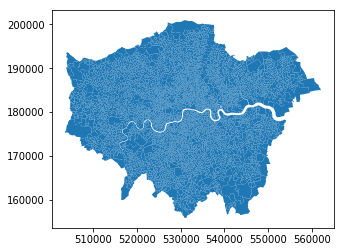

In [11]:
gdf2 = pd.merge(gdf, df, left_index=True, right_index=True)
print(type(gdf2))
print(" ")

print(gdf2.columns.values)
print(" ")

# Sometimes information about which column contains the geometry is lost
# after a merge or join and you need to tell GeoPandas where to find it 
# again. You'll see that, in this merge (on my computer at least), our 
# geometry column was renamed 'geometry_x' and so I needed to set the
# geometry again. The parameter inplace=True simply tells Python that 
# it shouldn't return a _new_ GeoPandas data frame.
gdf2.set_geometry('geometry_x', inplace=True) 

# What's different about this plot from the one above?
gdf2.plot()

# And save this as a _new_ shapefile...
mrg_path = os.path.join('shapes','LSOA Data.shp') # Where we saved the merged data
gdf2.to_file(mrg_path)

You can also _add_ other layers to the plot as long as you have access to the _axes_ (which will ensure that everything lines up properly):

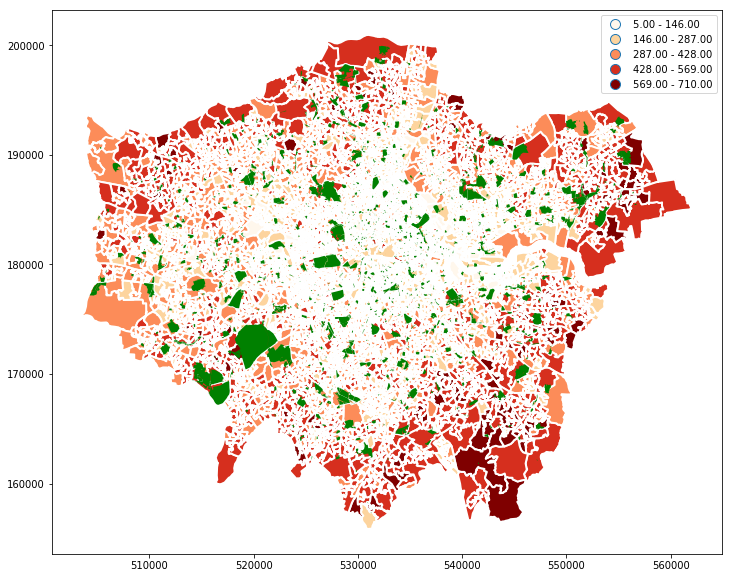

In [12]:
f, ax = plt.subplots(1, figsize=(12, 10))
base = gdf2.plot(ax=ax, column='Owned', cmap='OrRd', scheme='equal_interval', edgecolor='white', linewidth=2, legend=True)

parks = gpd.read_file(os.path.join('shapes/Greenspace/GLA Greenspace.shp'))
parks.plot(ax=ax, color='green');

**What's wrong with the map above?** How would you fix it by changing one or more of the parameters?

That's a nice overview, but it would be better if we could zoom in on, say, the south west for a closer look!

(165000, 180000)

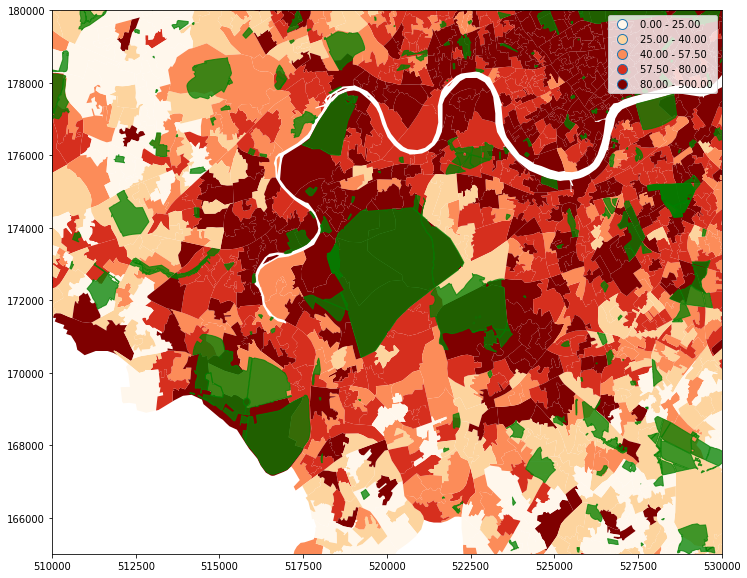

In [13]:
f, ax = plt.subplots(1, figsize=(12, 10))
base = gdf2.plot(ax=ax, column='MedianPrice', cmap='OrRd', scheme='quantiles', edgecolor=None, legend=True)

parks = gpd.read_file(os.path.join('shapes/Greenspace/GLA Greenspace.shp'))
parks.plot(ax=ax, color='green', alpha=0.75, edgecolor='green');
plt.xlim([510000, 530000]) # plt applies to the current plotting context (see plt.subplots above)
plt.ylim([165000, 180000])

#### More Fun!

You can find some more nice examples and applications from [GeoHackWeek](https://geohackweek.github.io/vector/04-geopandas-intro/)!

## Working with PySAL

Now that we've prepared the raw data, we're ready to begin a more substantive analysis using PySAL. Of course, at this stage we're still going to take it fairly easy and not jump feet-first into using concepts like spatial autocorrelation or spatially-aware statistics.

### Revisiting Classification

Classification matters. I realise that this topic can seem a little... _dry_, but perhaps this video will give you some sense of how the choices you make about representing your data can significantly alter your understanding of the data.

[![Do maps lie?](http://img.youtube.com/vi/G0_MBrJnRq0/0.jpg)](http://www.youtube.com/watch?v=G0_MBrJnRq0)

Like pandas/geopandas, PySAL has a classification 'engine' that we can use to bin data based on attribute values. Although it is possible _both_ to do some classification _without_ PySAL and to do some mapping _without_ GeoPands, the combination of the two is simplest: PySAL has additional classification methods that are _specific_ to geographic analysis problems, and GeoPandas is just plain easier to work with. 

The best-known geographical classification is Fisher-Jenks (also sometimes known as 'Natural Breaks'), which groups data into bins based on the sum of squared deviations between classes: in other words, the algorithm iteratively looks for ways to group the data into a specified number of bins such that moving a data point from one group to another would increase the total within-class deviation observed in the data.

But first, let's just go with **5 quantiles** (i.e. quintiles) and see how you can now work with PySAL:

In [ ]:
from pysal.contrib import pdio
from pysal.contrib.viz import mapping as maps
from pylab import *

PySAL expects `numpy` arrays instead of a Series, but fortunately it's easy to convert one to the other since Pandas/GeoPandas is built on top of numpy...

In [ ]:
prices = np.array(gdf2.MedianPrice) # Convert the DataSeries to an array
pricesq5 = ps.esda.mapclassify.???(prices, k=???) # Classify into 5 quantiles
print(pricesq5) # Print summary metrics

You should see:
```
                 Quantiles                 
 
 Lower            Upper               Count
===========================================
          x[i] <=  25.000               986
 25.000 < x[i] <=  40.000               973
 40.000 < x[i] <=  57.500               972
 57.500 < x[i] <=  80.000               982
 80.000 < x[i] <= 500.000               922
```
 
You can get at the class assignment for each LSOA using the code below. This becomes important because we need to copy these assignments _back_ on to the GeoPandas data frame in order to produce the plot:

In [ ]:
print(pricesq5.yb) # Class assignment (should be an array of class numbers)

Now we need to join our classification data _back_ on to the GeoPandas data frame as a new Series:

In [ ]:
gdf2['MedianPricesQ5'] = pd.Series(data=pricesq5.yb, index=gdf2.index)
f, ax = plt.subplots(1, figsize=(12, 8))
base = gdf2.plot(ax=ax, column='MedianPricesQ5', categorical=True, edgecolor=None, legend=True)

Let's try the same using 7 Fisher Jenks breaks (_**this may take some time... 75 seconds on my MacBook Air**_):

In [ ]:
#prices = np.array(gdf2.MedianPrice) # Already done so we don't need to run this again...
pricesFJ = ps.esda.mapclassify.???(???) # Classify into Natural Breaks
print(pricesFJ) # Print summary metrics

Your results should be:
```
                Fisher_Jenks                
 
 Lower            Upper                Count
============================================
          x[i] <=  16.000                782
 16.000 < x[i] <=  42.500               1276
 42.500 < x[i] <=  64.000               1176
 64.000 < x[i] <=  90.500                926
 90.500 < x[i] <= 132.000                508
132.000 < x[i] <= 220.000                144
220.000 < x[i] <= 500.000                 23
```

There are many colour maps (`cmap`s) supported: the map below is set up to use Viridis, but if you 'break' it by changing the spelling the error will give you a list of alternative colour maps!

In [ ]:
gdf2['MedianPricesFJ'] = pd.Series(data=pricesFJ.yb, index=gdf2.index)
f, ax = plt.subplots(1, figsize=(12, 8))
base = gdf2.plot(ax=ax, column=???, edgecolor=None, categorical=True, legend=True, cmap='viridis')

_**Why do you think we set the 'categorical' equal to True? What happens if you remove that?**_

### Putting it all together...

We can also look at how the Fisher-Jenks classification relates to the underlying distribution by plotting the prices and bin boundaries derived by PySAL. Notice how we get the boundaries (`b`) from the classifier (`pricesFJ`) to allow us to show the binning boundaries on our plot instead of the mean or standard deviation:

In [ ]:
f, ax = plt.subplots(1, figsize=(12, 4))

# Plot the prices
sns.kdeplot(prices, ax=ax, shade=True)

# Add the boundaries from the PySAL classifier
for b in pricesFJ.bins:
    plt.vlines(b, 0, 0.015, color='red', linestyle='--') 
    # Note that 0.015 was a _guess_ at the upper ylim (this can be done computationally)
    # What is slightly confusing is that '0' in the map above is a class (like 0 is 
    # also the index of an array) so a 7-class grouping gives you a legend with range 1--6.

So using the map and the Seaborn plot together it becomes much easier to determine whether the classification is appropriate and whether the results are meaningful.

### Where to find more information

You can see the full list of supported classification engines on the PySAL documentation (under [`psyal.esda`](http://pysal.readthedocs.io/en/latest/library/esda/mapclassify.html)).

### Additional 'playing' around

To make it easier to see what's happening in Central London why don't we try zooming in a little bit? Playing around with the earlier code, see if you can't figure out how to zoom in to something like:

Dimension | Max/Min | Value 
--------- | ------- | -----
Northing | Max | 190000
Northing | Min | 170000
Easting | Max | 540000
Easting | Min | 520000

Some additional constraints:
* Select only those LSOAs with a MedianPrice > 0
* Log-transform _and_ IQR-Standardise your MedianPrice data to be closer to normally distributed
* Use the Std_Mean classifier

Your classes should look like this:
```
                 Std_Mean                 
 
Lower            Upper               Count
==========================================
         x[i] <= -1.443                 56
-1.443 < x[i] <= -0.711                600
-0.711 < x[i] <=  0.753               2744
 0.753 < x[i] <=  1.485                583
 1.485 < x[i] <=  3.278                 84
```
I'll give you some more clues on output below...

In [ ]:
# Your code to derive standardised values here...

# Step 1: filter out places where Median Price is 0
#         gdf2s == gdf2-selection
gdf2s = gdf2[???].copy()

# Step 2: calculate the natural log of the median price
gdf2s['LogMedianPrice'] = ???

# Step 3: IQR-standardise the data
gdf2s['LogMedPriceStd'] = ???

# Step 4: produce a distribution plot of the standardised data
sns.distplot(gdf2s.LogMedPriceStd, kde=False)

# Step 5: extract prices as numpy array and classify using Standard Deviations from the Mean
prices = np.array(gdf2s.LogMedPriceStd)  
pricesStd = ps.esda.mapclassify.???(prices) 

# Step 6: check results
print(pricesStd) 

# Step 7: copy back classes to new column in gdf2s
gdf2s['LogMedPriceStdClasses'] = pd.Series(pricesStd.yb, index=gdf2s.index)

I've used the 'plasma' scheme below, but here is the full list of support colour schemes in matplotlib (your list _may_ vary somewhat depending on what you've installed... though it _shouldn't_):
```python
Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spectral, spectral_r, spring, spring_r, summer, summer_r, terrain, terrain_r, viridis, viridis_r, winter, winter_r
``` 

In [ ]:
# Your code here....

f, ax = plt.subplots(1, figsize=(12, 10))
base = gdf2s.plot(ax=ax, ???)

parks = ???
parks.plot(ax=ax, color=(0.1, 0.5, 0.2), alpha=0.75, edgecolor='green')

roads = ???
roads.plot(ax=ax, color='grey')

plt.axis(???) # Have a look at: http://darribas.org/gds17/content/labs/lab_03.pdf for clues
ax.set_xlim(???)
ax.set_ylim(???)

It should be possible to load the roads and parks and get something like the below as a map:

![Map of Central London (Standardised Log-Price)](https://github.com/kingsgeocomp/geocomputation/blob/master/img/LogMedPriceStd_Plasma_Map.png?raw=true)

## Testing Your Understanding

Over to you! I'd like you to test [a number of the `mapclassify` options](http://pysal.readthedocs.io/en/latest/library/esda/mapclassify.html) and make up your own mind as to which is the 'best' for classifying the `Owned` column. To do this you will need to think about how you can automate the steps we've taken above, including:

* Loading the data
* Running the classifer
* Outputting it to a map
* Outputting the distribution with bin boundaries
* Looking at 'goodness-of-fit' metrics (see the [documentation](http://pysal.readthedocs.io/en/latest/library/esda/mapclassify.html) and, in particular, `get_acdm`, `get_gadf`, and `get_tss`)

To make sure that you've done all of this correctly you should be able to click on 'Kernel' > 'Restart' and then run _only_ the code in the block below fully and successfully. So you'll need to factor in things like loading the libraries that you'll need, telling the notebook where to find the data, etc.

### Getting More Help/Applications

A great resource for more help and more examples is Dani Arribas-Bel's _Geographic Data Science_ module: he has put all of his [module practicals online](http://darribas.org/gds17/) (as we have too), and you might find that something that he does makes more sense to you than what we've done... check it out!

### An Additional Challenge

Although we can't give you bonus points, you might like to think about how you could, for instance, show borough boundaries and other features on the map to improve its legibility. At the extreme end, it should be possible to, for instance, log-transform your Ownership data, select only the LSOAs where this value is > 0, and then classify only the non-zero values using a 'Standard Deviations from the Mean' classification... You would then want to show a base map that has grey to denote 'zero' and superimpose the colours on top of that...